**Can a player's age and total hours played predict whether they subscribe to a game-related newsletter?**

**Introduction:**
Video games generate rich behavioural data, offering insights not only into player engagement but also into broader patterns of human-computer interaction. As gaming platforms grow in complexity, understanding user behaviour becomes increasingly valuable for server planning, targeted communication, and improving player experience. In particular, predicting which players are likely to subscribe to a game's newsletter can help game developers and researchers direct outreach efforts and resource allocation.

In this project, we analyze player behaviour data collected from a Minecraft research server maintained by a computer science group at the University of British Columbia (UBC). The server tracks users' individual play sessions, allowing us to aggregate behavioural features for each player. The project’s goal is to explore whether these behavioural patterns can be used to predict which players are most likely to subscribe to a game-related newsletter. The guiding question for the project is:
**Can a player's age and total hours played predict whether they subscribe to a game-related newsletter?** 

To analyze this, we will be looking at a dataset that includes the following columns:

* `experience`: the player's self-reported experience level with Minecraft. It reflects how familiar or skilled they consider themselves to be (beginner, amateur, regular, veteran, pro)
* `subscribe`: shows whether the player subscribed to a game-related newsletter
* `hashedEmail`: represents an anonymized unique identifier for each player
* `played_hours`: the amount of hours of the game played by the player
* `name`: the name of the player
* `gender`: the gender of the player (male/female)
* `age`: the age of the player

To begin the analysis, it is necessary to load the R packages that will be used for the analysis:

In [19]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
library(themis)

options(repr.matrix.max.rows = 6)

Then, I read in the players.csv data using read_csv() and assigned it to objects called players and sessions.

In [20]:
players <- read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


As we are only working with the player's experience level, total hours played, and whether they subscribed or not, I removed the other columns for analysis clarity. I then removed players with missing age or played_hours, renamed my columns and changed subscribed into a factor so analysis can be easier. 

In [31]:
players_data <- players |>
    select(played_hours, subscribe, Age) |>
    filter(!is.na(played_hours), !is.na(Age)) |>
    rename(is_subscribed = subscribe, age = Age) |>
    mutate(is_subscribed = as.factor(is_subscribed))

players_data

played_hours,is_subscribed,age
<dbl>,<fct>,<dbl>
30.3,TRUE,9
3.8,TRUE,17
0.0,FALSE,17
⋮,⋮,⋮
0.3,FALSE,22
0.0,FALSE,17
2.3,FALSE,17


I then took this data and split it into a test and training test, using 70% of the data and then setting subscribe as the strata argument.

In [ ]:
set.seed(1234) #so it can be reproduced

players_split <- initial_split(players_data, prop = 0.7, strata = is_subscribed)
players_training <- training(players_split)
players_testing <- testing(players_split)

I then wanted to visualize the training data to see if oversampling needed to be done, so I used a scatter plot to plot it.

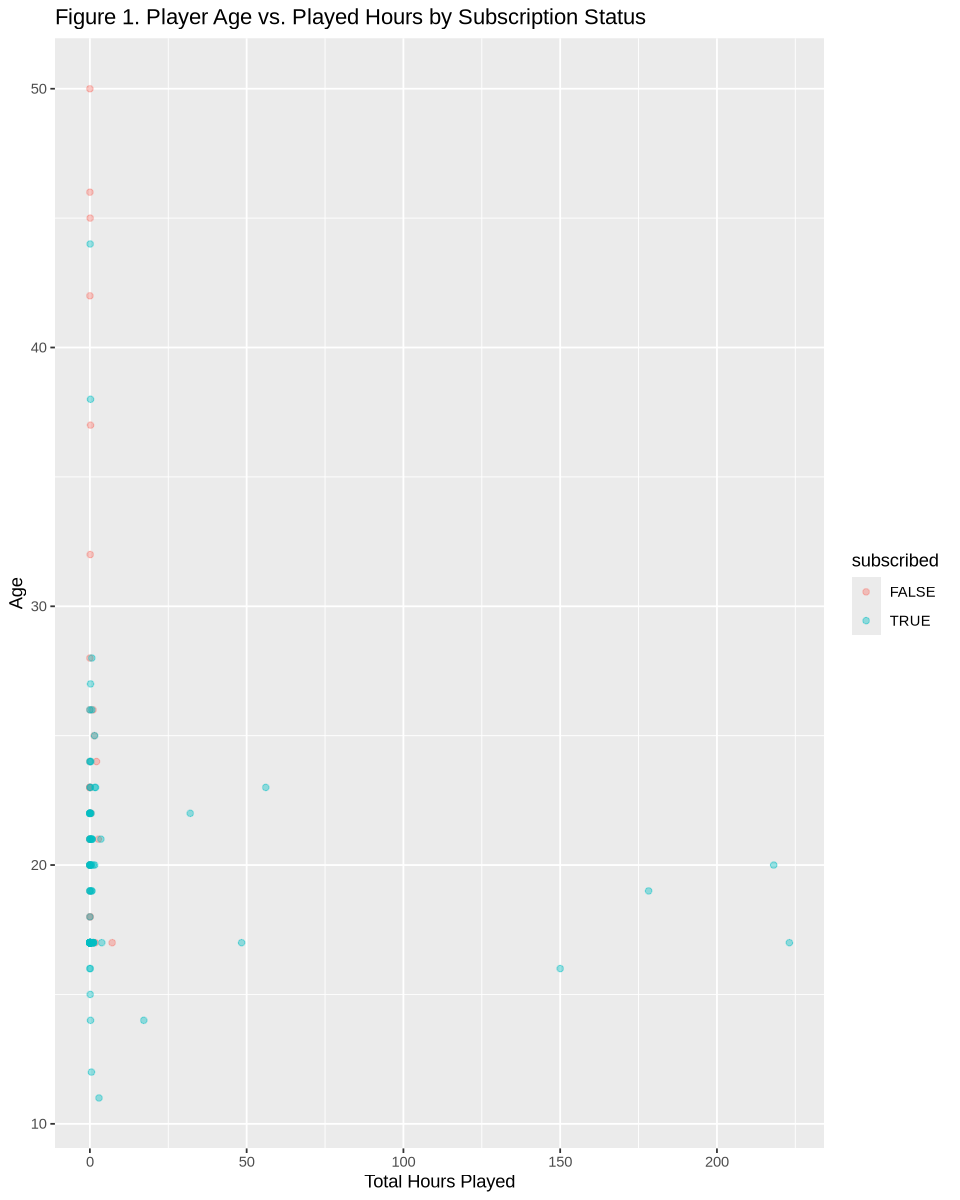

In [88]:
options(repr.plot.width = 8, repr.plot.height = 10)

training_plot <- players_training |>
    ggplot(aes(x = played_hours, y = age, color = is_subscribed)) +
  geom_point(alpha = 0.4) +
  labs( title = "Figure 1. Player Age vs. Played Hours by Subscription Status", 
    x = "Total Hours Played",
    y = "Age",
    color = "subscribed")

training_plot

From initial visualizations, there does not seem to be a trend between age, hours played and subscription status. I also noticed that there were more people who were subscribed than not, so I tested if the number of FALSE and TRUE was balanced. 

In [89]:
counts <- players_training |> 
    group_by(is_subscribed) |> 
    summarize(count=n())

counts

is_subscribed,count
<fct>,<int>
FALSE,36
TRUE,99


There were more FALSE than TRUE, so in my recipe, I will oversample FALSE. In order to do this, I will use the step_upsample function to create a recipe that includes scaled predictors.

In [90]:
set.seed(1234)
players_recipe <- recipe(is_subscribed ~ played_hours + age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(is_subscribed, over_ratio = 1, skip = TRUE)

I then created a model specification with tuning to complete a 5-fold cross validation on it in order to find the best $K$ value and combined the recipe, folds and model specification into a workflow analysis to build the classifier. I decided to test $K$ values from 1 to 10 as more $K$ values would be too strenuous on my computer. 

In [91]:
set.seed(1234)
players_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = is_subscribed)

players_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_tune_spec) |>
    tune_grid(resamples = players_vfold, grid = tibble(neighbors = 1:10)) |>
    collect_metrics()

Then, I found the best $K$ value. To do this, from players_results, I filtered for accuracy from the .metric column. Then, I created a line plot using the accuracy dataset with neighbours on the x-axis and the mean on the y-axis.

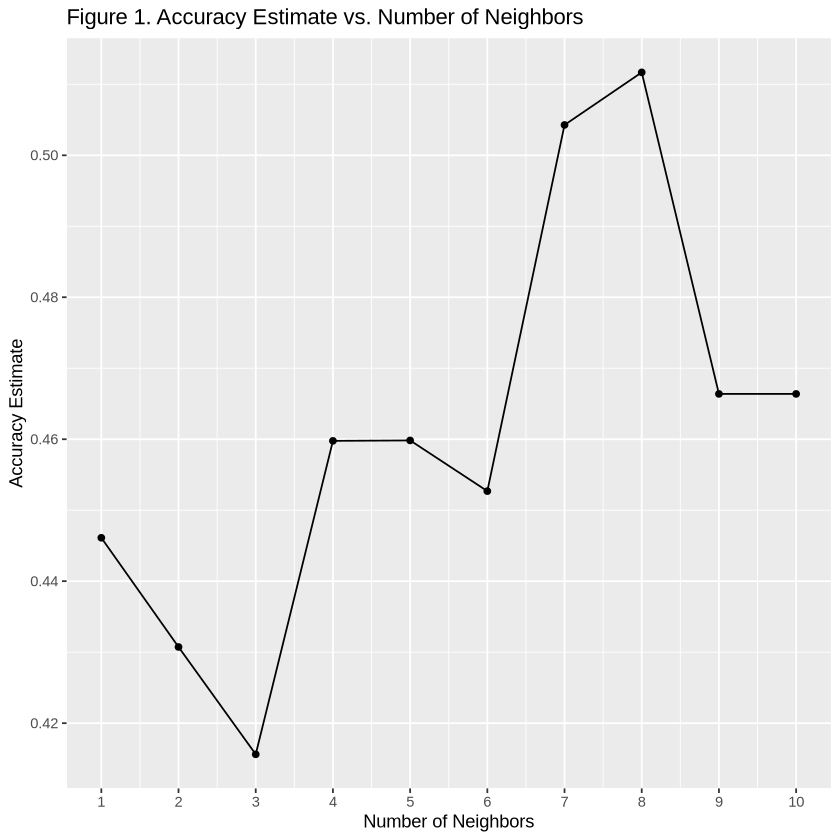

In [82]:
set.seed(1234)
accuracies <- players_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(title = "Figure 2. Accuracy Estimate vs. Number of Neighbors", x = "Number of Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1))  # adjusting the x-axis
accuracy_versus_k

From the plot above, it can be seen that using $K$ value of 8 leads to the highest accuracy. We can be sure as cross-validation was used to find this value. I will first build my model specification with $K$ value. Then, I passed the model specification and the training dataset to the fit() function.

In [85]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = players_training)

I used my final model to predict on the test dataset, then reported the accuracy of this prediction, and store this in an object named mnist_metrics. Then, I created a confusion matrix.

In [86]:
players_predictions <- predict(players_fit, players_testing) |>
                        bind_cols(players_testing)

players_metrics <- players_predictions |> metrics(truth = is_subscribed, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                        conf_mat(truth = is_subscribed, estimate = .pred_class) 
players_metrics
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.37288136
kap,binary,0.03705337


          Truth
Prediction FALSE TRUE
     FALSE    14   35
     TRUE      2    8